<a href="https://colab.research.google.com/github/Yanina-Kutovaya/GNN/blob/main/notebooks/4_GIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация Graph Isomorphism Network (GIN) из PyTorch Geometric для классификации узлов на датасете Bitcoin-OTC с обработкой признаков рёбер

Задача — предсказать "уровень доверия" пользователей

Признаки узлов/рёбер - синтетические

Необходимо выбрать среду выполнения с GPU: Runtime → Change runtime type → GPU

## 1. Установка зависимостей

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


* Google Colab иногда возникают проблемы с кэшированием пакетов, поэтому добавлен флаг ```--no-cache-dir ```

In [2]:
install = True
if install:
  # 1. Установка совместимых версий PyTorch и PyG
  !pip install -q torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

  # 2. Установка зависимостей PyG для CUDA 12.1+ (совместимо с 12.5)
  !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html --no-cache-dir

  # 3. Установка PyTorch Geometric
  !pip install -q torch-geometric==2.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

### Принудительная перекомпиляция расширений

In [3]:
!python -c "import torch; import torch_geometric; print('Rebuild success')"

Rebuild success


### Проверка окружения

In [4]:
import torch
print(f"PyTorch: {torch.__version__}")          # Должно быть 2.3.0+cu121
print(f"CUDA: {torch.version.cuda}")            # Должно быть 12.1+
print(f"Available: {torch.cuda.is_available()}")# Должно быть True

PyTorch: 2.3.0+cu121
CUDA: 12.1
Available: True


## 2. Импорт библиотек

In [5]:
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.datasets import BitcoinOTC
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GINConv
from torch.nn import Linear, Sequential, ReLU

import matplotlib.pyplot as plt

## 3. Загрузка и подготовка данных

Обработка признаков:
* Агрегация признаков рёбер через суммирование
* Нормализация всех признаков
* Явное преобразование типов данных

In [6]:
dataset = BitcoinOTC(root='/tmp/BitcoinOTC')
data = dataset[0]

Extracting /tmp/BitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


### 3.1 Создание синтетических признаков узлов

In [7]:
degrees = np.zeros(data.num_nodes)
for edge in data.edge_index.t().tolist():
    degrees[edge[0]] += 1  # Исходящая степень

data.x = torch.tensor(degrees, dtype=torch.float).view(-1, 1)
data.x = (data.x - data.x.mean()) / data.x.std()

### 3.2 Создание меток (3 класса)

In [8]:
labels = torch.zeros(data.num_nodes, dtype=torch.long)
q1 = np.quantile(degrees, 0.33)
q2 = np.quantile(degrees, 0.66)
labels[degrees > q2] = 2
labels[(degrees > q1) & (degrees <= q2)] = 1
data.y = labels

### 3.3 Разделение данных

In [9]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

indices = torch.randperm(data.num_nodes)
split = [0.6, 0.2, 0.2]
data.train_mask[indices[:int(split[0]*data.num_nodes)]] = True
data.val_mask[indices[int(split[0]*data.num_nodes):int((split[0]+split[1])*data.num_nodes)]] = True
data.test_mask[indices[int((split[0]+split[1])*data.num_nodes):]] = True

## 4. Определение модели GIN

Архитектура GIN:
- Два GIN-слоя с MLP внутри
- Dropout (0.5) для регуляризации
- Нормализация признаков узлов

In [10]:
class GINNeighborSampler(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GINConv(
            Sequential(
                Linear(in_channels, hidden_channels),
                ReLU(),
                Linear(hidden_channels, hidden_channels)
            )
        )

        self.conv2 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels),
                ReLU(),
                Linear(hidden_channels, out_channels)
            )
        )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge_index)

## 5. Инициализация модели и оптимизатора

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GINNeighborSampler(1, 64, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 6. Настройка NeighborLoader

Neighborhood Sampling:
- Использование NeighborLoader для эффективной загрузки подграфов
- Балансировка между глубиной сети (2 слоя) и размером выборки
- Параметры: 25 соседей на первом слое, 10 на втором

In [12]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[25, 10],  # 25 соседей для 1-го слоя, 10 для 2-го
    batch_size=512,
    input_nodes=data.train_mask,
    shuffle=True,
    num_workers=2
)

## 7. Функция для вычисления точности

In [13]:
def accuracy(pred, true, mask):
    return (pred[mask].argmax(dim=1) == true[mask]).sum().float() / mask.sum()

## 8. Обучение модели

In [14]:
losses = []
val_accs = []

model.train()
for epoch in range(20):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_acc = accuracy(model(data.x.to(device), data.edge_index.to(device)), data.y.to(device), data.val_mask.to(device))

    losses.append(total_loss / len(train_loader))
    val_accs.append(val_acc.cpu())

    print(f'Epoch {epoch:02d} | Loss: {losses[-1]:.4f} | Val Acc: {val_acc:.4f}')

Epoch 00 | Loss: 0.8068 | Val Acc: 1.0000
Epoch 01 | Loss: 0.0461 | Val Acc: 1.0000
Epoch 02 | Loss: 0.0359 | Val Acc: 1.0000
Epoch 03 | Loss: 0.0220 | Val Acc: 1.0000
Epoch 04 | Loss: 0.0159 | Val Acc: 1.0000
Epoch 05 | Loss: 0.0159 | Val Acc: 1.0000
Epoch 06 | Loss: 0.0084 | Val Acc: 0.9992
Epoch 07 | Loss: 0.0086 | Val Acc: 1.0000
Epoch 08 | Loss: 0.0091 | Val Acc: 1.0000
Epoch 09 | Loss: 0.0086 | Val Acc: 1.0000
Epoch 10 | Loss: 0.0084 | Val Acc: 1.0000
Epoch 11 | Loss: 0.0089 | Val Acc: 1.0000
Epoch 12 | Loss: 0.0073 | Val Acc: 1.0000
Epoch 13 | Loss: 0.0076 | Val Acc: 1.0000
Epoch 14 | Loss: 0.0072 | Val Acc: 1.0000
Epoch 15 | Loss: 0.0073 | Val Acc: 1.0000
Epoch 16 | Loss: 0.0077 | Val Acc: 1.0000
Epoch 17 | Loss: 0.0077 | Val Acc: 1.0000
Epoch 18 | Loss: 0.0227 | Val Acc: 1.0000
Epoch 19 | Loss: 0.0102 | Val Acc: 1.0000


## 9. Визуализация обучения

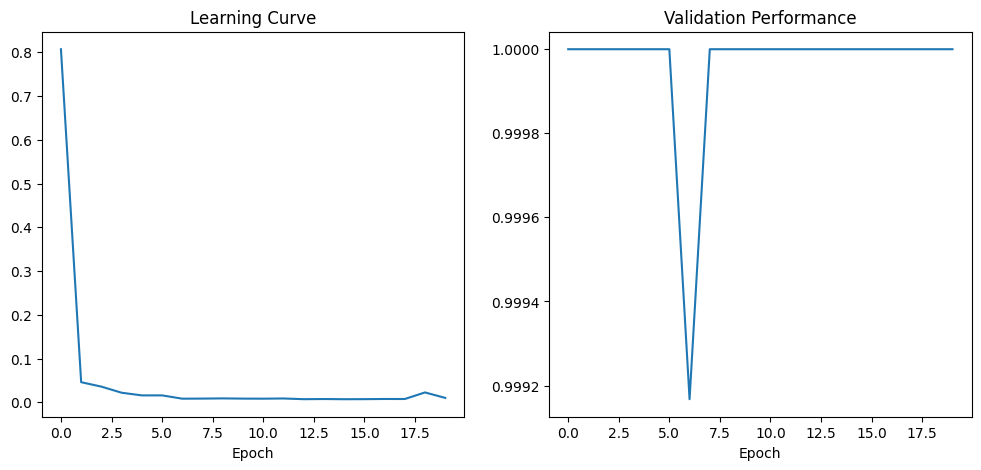

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Performance')
plt.xlabel('Epoch')
plt.show()

## 10. Тестирование

In [16]:
model.eval()
with torch.no_grad():
    test_acc = accuracy(model(data.x.to(device), data.edge_index.to(device)), data.y.to(device), data.test_mask.to(device))
    print(f'\nFinal Test Accuracy: {test_acc:.4f}')


Final Test Accuracy: 0.9983


## 11. Возможные улучшения:

- Добавление внимания к ребрам через edge_attr
- Эксперименты с глубиной сети
- Подбор гиперпараметров через Optuna
- Использование более сложных признаков узлов